In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cd /content/gdrive/MyDrive/kaggle

In [ ]:
#!mkdir /content/gdrive/MyDrive/kaggle/data
#!unzip /content/gdrive/MyDrive/kaggle/aptos2019-blindness-detection.zip -d /content/gdrive/MyDrive/kaggle/data 
!ls /content/gdrive/MyDrive/kaggle/data/

 assets			  history.json		  saved_model.pb
 graph-model1-1acc.png	  history-model1-1.csv	 'submission (1).gsheet'
 graph-model1-1loss.png   model1		  submission.csv
 graph-model1-acc.png	  model1-1.h5		  submission.gsheet
 graph-model1-loss.png	  model2		  test.csv
 graph-model2-acc.png	  model2.h5		  test_images
 graph-model2-loss.png	  model2-submission.csv   train.csv
 graph-model3-1acc.png	  preview		  train_images
 graph-model3-1loss.png   sample_submission.csv   variables


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("/content/gdrive/MyDrive/kaggle/data"))
#https://www.kaggle.com/gkcsml1020/aptos-blindness-detection-basic-cnn/edit

['test.csv', 'sample_submission.csv', 'train.csv', 'test_images', 'train_images', 'submission (1).gsheet', 'preview', 'submission.gsheet', 'variables', 'assets', 'saved_model.pb', 'model1', 'graph-model1-acc.png', 'graph-model1-loss.png', 'model2', 'model1-1.h5', 'history.json', 'history-model1-1.csv', 'graph-model1-1acc.png', 'graph-model1-1loss.png', 'submission.csv', 'model2.h5', 'graph-model2-acc.png', 'graph-model2-loss.png', 'model2-submission.csv', 'graph-model3-1acc.png', 'graph-model3-1loss.png']


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/kaggle/data/train.csv')
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'

In [ ]:
train_df['id_code'].sample(1)

1315    5b5b80a3edee.png
Name: id_code, dtype: object

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#create a new model of type Sequential. We then iterate over each of the layers in vgg16_model, except for the last layer, and add each layer to the new Sequential model.
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [ ]:
#iterate over each of the layers in our new Sequential model and set them to be non-trainable. This freezes the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our images
for layer in model.layers:
    layer.trainable = False
#is this a good idea for medical images, knowng we are working on imagenet data ?
model.add(Dense(units=5, activation='softmax'))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
    #zca_whitening = True)

batch_size = 16
image_size = 224

train_image_path = '/content/gdrive/MyDrive/kaggle/data/train_images'
test_image_path = '/content/gdrive/MyDrive/kaggle/data/test_images'


train_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_path,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    target_size=(image_size,image_size),
    subset='training')

test_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_path,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical", 
    target_size=(image_size,image_size),
    subset='validation')





Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [ ]:
test_gen

In [ ]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

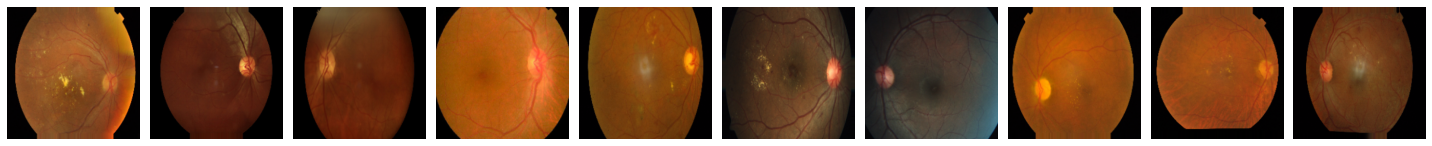

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
#get this to show labels beside the image 
imgs, labels = next(train_gen)
plotImages(imgs)
print(labels)

In [ ]:
#get this to show labels beside the image 
imgs, labels = next(train_gen)
plotImages(imgs)
print(labels)

In [ ]:
y_train = train_df['diagnosis']
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]


In [ ]:
#https://deeplizard.com/learn/video/oDHpqu52soI
#bets tutorial so far on transfer learning 
#iterating over eac of the layers except the last
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [ ]:
#iterate over layers and set them to non trainable 
for layer in model.layers:
    layer.trainable = False


#in reality, freezibg layers is not a solution for medical imaging data, which could be sparsely represented in hte imagenet dataset 
#check the results after freezing the output 

In [ ]:
model.add(Dense(units=5, activation='softmax'))
#only trainable layer in the mode l, 5 classes not 1000 
#fine tuning the model 


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_gen,
          steps_per_epoch=len(train_gen),
          validation_data=test_gen,
          validation_steps=len(test_gen),
          epochs=3,
          verbose=2
)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
 

Epoch 1/3
184/184 - 1357s - loss: 1.2896 - accuracy: 0.5010 - val_loss: 1.3179 - val_accuracy: 0.4604
Epoch 2/3
184/184 - 1142s - loss: 1.2895 - accuracy: 0.5010 - val_loss: 1.3180 - val_accuracy: 0.4604
Epoch 3/3
184/184 - 1115s - loss: 1.2893 - accuracy: 0.5010 - val_loss: 1.3181 - val_accuracy: 0.4604


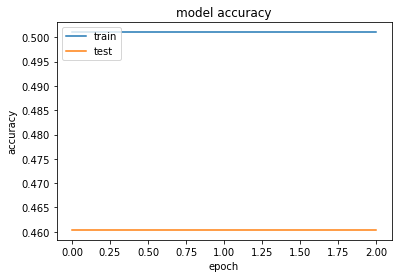

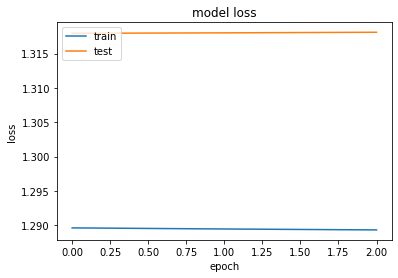

In [ ]:
#plot learning curve 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/kaggle/data/graph-model3-1acc')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/kaggle/data/graph-model3-1loss')
plt.show()

In [ ]:
#3 epochs are not sufficient
# does increasing the learning rate result in faster training?
# if it does, then can we take observations over more epochs ?
#create a new model object for this iteration
#learning rate .1 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

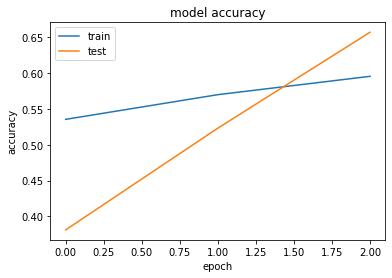

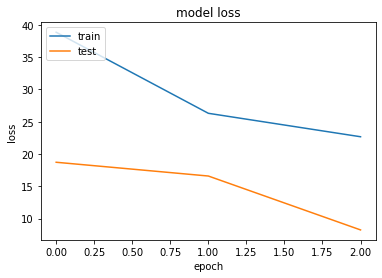

In [ ]:
model2 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model2.add(layer)

for layer in model2.layers:
  layer.trainable = False

model2.add(Dense(units=5, activation='softmax'))
model2.summary()

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(x=train_gen,
          steps_per_epoch=len(train_gen),
          validation_data=test_gen,
          validation_steps=len(test_gen),
          epochs=3,
          verbose=2
)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '/content/gdrive/MyDrive/kaggle/results/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/gdrive/MyDrive/kaggle/results/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


#plot learning curve 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/kaggle/data/graph-model3-2acc')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/kaggle/data/graph-model3-2loss')
plt.show()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

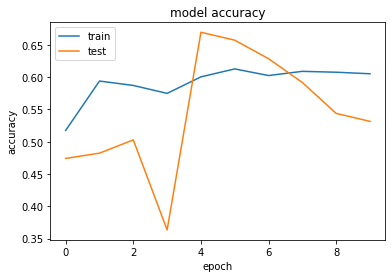

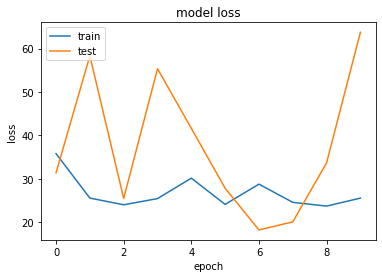

In [ ]:
model3 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model3.add(layer)

for layer in model3.layers:
  layer.trainable = False

model3.add(Dense(units=5, activation='softmax'))
model3.summary()

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

history = model3.fit(x=train_gen,
          steps_per_epoch=len(train_gen),
          validation_data=test_gen,
          validation_steps=len(test_gen),
          epochs=10,
          verbose=2
)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '/content/gdrive/MyDrive/kaggle/results/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/gdrive/MyDrive/kaggle/results/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


#plot learning curve 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/kaggle/data/graph-model3-2acc')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/kaggle/data/graph-model3-2loss')
plt.show()

In [ ]:
submission_df = pd.read_csv('/content/gdrive/MyDrive/kaggle/data/sample_submission.csv')
#submission_df['diagnosis'] = submission_df['diagnosis'].astype('str')
submission_df['filename'] = submission_df['id_code'].astype(str)+'.png'

In [ ]:
sub_image_path = '/content/gdrive/MyDrive/kaggle/data/test_images'
submission_datagen=ImageDataGenerator(rescale=1./255)
submission_gen=submission_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory=sub_image_path,
    x_col="filename",    
    batch_size=batch_size,
    shuffle=False,
    class_mode=None, 
    target_size=(image_size,image_size)
)

Found 1928 validated image filenames.


In [ ]:
predictions = model.predict(x=submission_gen, steps=len(submission_df), verbose=2)

1928/1928 - 535s


In [ ]:
cm = confusion_matrix(y_true=submission_gen.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['0','1', '2', '3', '4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')